In [1]:

# see equations in one-Note

import numpy as np                                             # dense matrices
import matplotlib.pyplot as plt                                # plotting
from scipy.stats import multivariate_normal                    # multivariate Gaussian distribution
import copy                                                    # deep copies

# image handling library
from PIL import Image
from io import BytesIO

#%% Step 1: Log-Likelihood calculation

# mathematical trick to avoid over and underflow: 
# https://math.stackexchange.com/questions/4480736/computing-the-log-of-a-sum-of-exponentials

def log_sum_exp(Z):
    """ Compute log(\sum_i exp(Z_i)) for some array Z."""
    return np.max(Z) + np.log(np.sum(np.exp(Z - np.max(Z))))


""" 
Log likelihood formula for the gaussian mixture model, page 7 of pdf:
    https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec15_16_handout.pdf
    
    The log likelihood quantifies the probability of observing a given set of 
    data under a particular setting of the parameters in our model.
    
    
    """
    
def loglikelihood(data, weights, means, covs):
    """ Compute the loglikelihood of the data for a Gaussian mixture model with the given parameters. """
    
    #following page 7 for the overall equation: https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec15_16_handout.pdf
    
    num_clusters = len(means)
    num_dim = len(data[0])
    
    ll = 0 
    
    # outer loop (summation over datapoints in log-likelihood)
    for d in data:
        
        # inner loop will calculate the probability of each data point belonging to 
        # each Gaussian component (each cluster/distribution that is combined to make the overall 
        # gaussian mixture model)
        
        contributionOfDataPointToEachCluster = np.zeros(num_clusters)
        
        for k in range(num_clusters):
            
            # check pdf page 61, for equations: https://www.cs.toronto.edu/~urtasun/courses/CSC411_Fall16/13_mog.pdf
            #(x-mu); one of the intermediate components
            dataPointMinusMeans = np.array(d) - means[k]
            
            # np.linalg.inv(covs[k]) ==> inverse of covaraince
            exponentInNormalDistributionOfDataPoint = np.dot(dataPointMinusMeans.T, 
                                                             np.dot(np.linalg.inv(covs[k]), dataPointMinusMeans))
            
            
            # # Compute loglikelihood contribution for this data point and this cluster
            
            contributionOfDataPointToEachCluster[k] += np.log(weights[k])
            
            contributionOfDataPointToEachCluster[k] -= 1/2* (num_dim * np.log(2*np.pi) + 
                                                             np.log(np.linalg.det(covs[k])) + 
                                                             exponentInNormalDistributionOfDataPoint)
            
        # increment loglikelihood contribution of this data point across all clusters
        ll += log_sum_exp(contributionOfDataPointToEachCluster)
        
    return ll
            
            
            
#%% Step 2: E-step: assign cluster responsibilities, given current parameters
        
"""
E-Step: 
The first step in the EM algorithm is to compute cluster responsibilities. Let rik denote the
 responsibility of cluster k for data point i.. 
 
 SciPy provides a convenient function multivariate_normal.pdf that computes 
 the likelihood of seeing a data point in a multivariate Gaussian distribution. The usage is :
     
     multivariate_normal.pdf([data point], mean=[mean vector], cov=[covariance matrix])
 
"""

def compute_responsibilities(data, weights, means, covariances):
    
    '''E-step: compute responsibilities, given the current parameters'''
    
    num_data = len(data)
    
    num_clusters = len(means)
    
    # responsibility is a matrix because it is defined as a responsibility of each data point i
    # towards cluster k
    resp = np.zeros((num_data, num_clusters))
    
    # Update resp matrix so that resp[i,k] is the responsibility of cluster k for data point i.
    # To compute likelihood of seeing data point i given cluster k, use multivariate_normal.pdf.

    for i in range(num_data):
        
        for k in range(num_clusters):
            
            resp[i,k] = weights[k] * multivariate_normal.pdf(data[i], mean=means[k], cov=covariances[k])
    
    
    # Add up responsibilities over each data point and normalize
    # in normalization addition happens over the clusters k, so axis 1
    row_sums = resp.sum(axis = 1)[: , np.newaxis]
    
    resp = resp/row_sums
    
    return resp

""" Checkpoint: testing compute_responsibilities function for error"""
"""
covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
say I have two distributions distribution 1 and distributuion2
in each distribution i have two colors say red and green

so distribution 1 covariance will be: [sigmasquared(red),  sigma(red,green)
                                       sigma(green,red), sigmasquared(green)]
similar will be for distribution 2 and they are clubbed together

since at the end we are looking for a overall gaussian.. (combination of all distributions)

"""
resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])

if resp.shape==(2,2) and np.allclose(resp, np.array([[0.10512733, 0.89487267], [0.46468164, 0.53531836]])):
    print('Checkpoint passed!')
else:
    print("Error in Implementation")
    
#%% Step 3: M-step: Update parameters, given current cluster responsibilities; page 24 for equations: https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec15_16_handout.pdf


"""
Once the cluster responsibilities are computed, we update the parameters 
(weights, means, and covariances) associated with the clusters.

part a: compute soft counts
part b: update weights
partc: update mean
part d: update co-variance


"""

"""
Computing soft counts. Before updating the parameters, we first compute what is
 known as "soft counts". The soft count of a cluster is the sum of all cluster responsibilities for that cluster
"""
def compute_soft_counts(resp):
    
    # this will be summed up over each data point. 
    # see the equation in One_note, part 3 or 
    #page-24, (https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec15_16_handout.pdf)
    
    counts = np.sum(resp, axis = 0)   # dimension 1 by k
    
    return counts

"""
Commpute Weights: The cluster weights show us how much each cluster is represented over all data points.

"""

def compute_weights(counts):
    
    num_clusters = len(counts)
    weights = [0.]* num_clusters
    
    for k in range(num_clusters): # this loop is just to update the kth cluster and not summing over it
        
        # Update the weight for cluster k using the M-step update rule for the cluster weight
        
        weights[k] = counts[k]/np.sum(counts)   # np.sum(counts) (summed up over all cluster axis)
        
        #print("np.sum(counts)",np.sum(counts))
    return weights

""" Checkpoint: testing weights function for error"""

resp = compute_responsibilities(data=np.array([[1.,2.],[-1.,-2.],[0,0]]), weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
weights = compute_weights(counts)



if np.allclose(weights, [0.27904865942515705, 0.720951340574843]):
    print('Checkpoint passed!')
else:
    print("Error in Implementation")

    

"""

Commpute Means: The mean of each cluster is set to the weighted average of
                all data points, weighted by the cluster responsibilities..
                
"""

def compute_means(data, resp, counts):
    
    num_clusters = len(counts)
    num_data = len(data)
    means = [np.zeros(len(data[0]))] * num_clusters
    
    for k in range(num_clusters):  # this loop is just to update the kth cluster and not summing over it
        
        # Update means for cluster k using the M-step update rule for the mean variables.
        
        weighted_sum = 0
        
        # check out the equation. https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec15_16_handout.pdf
        # page 24
        for i in range(num_data):
            
            weighted_sum += data[i]* resp[i][k]
            
            
        means[k] = weighted_sum/counts[k]
        
    return means
    
""" Checkpoint: testing Means function for error"""

data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)

if np.allclose(means, np.array([[-0.6310085, -1.262017], [0.25140299, 0.50280599]])):
    print('Checkpoint passed!')
else:
    print("Error in Implementation")

"""

Commpute Co-variance: The covariance of each cluster is set to the weighted average of 
all outer products, weighted by the cluster responsibilities..
Look in page (24): https://www.cs.toronto.edu/~jlucas/teaching/csc411/lectures/lec15_16_handout.pdf
                
"""
def compute_covariances(data, resp, counts, means):
    num_clusters = len(counts)
    num_dim = len(data[0])
    num_data = len(data)
    covariances = [np.zeros((num_dim,num_dim))] * num_clusters
    
    for k in range(num_clusters):
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        weighted_sum = np.zeros((num_dim, num_dim))
        for i in range(num_data):
            
            weighted_sum += resp[i][k]*np.outer(data[i] - means[k], data[i] - means[k])
        
        covariances[k] = weighted_sum / counts[k]

    return covariances
""" Checkpoint: testing Co-varaince function for error"""
data_tmp = np.array([[1.,2.],[-1.,-2.]])
resp = compute_responsibilities(data=data_tmp, weights=np.array([0.3, 0.7]),
                                means=[np.array([0.,0.]), np.array([1.,1.])],
                                covariances=[np.array([[1.5, 0.],[0.,2.5]]), np.array([[1.,1.],[1.,2.]])])
counts = compute_soft_counts(resp)
means = compute_means(data_tmp, resp, counts)
covariances = compute_covariances(data_tmp, resp, counts, means)

if np.allclose(covariances[0], np.array([[0.60182827, 1.20365655], [1.20365655, 2.4073131]])) and \
    np.allclose(covariances[1], np.array([[ 0.93679654, 1.87359307], [1.87359307, 3.74718614]])):
    print('Checkpoint passed!')
else:
    print("Error in Implementation")
    
#%% EM Algorithm

"""
1. initialize parameters mean, covariance and weight
2. initialize log-likelihood (over mean, co-variance and wiehgt from step 1)

3. Give some iteration numbers (max_iter), say equal to 10 or 20, for which E and M-step will run. 

    3a. E-Step: compute responsibility (using initial weight, mean, covariance and datapoints)
    3b. M-Step: compute weights, means, covariances
    
    3c. compute log-likelihood.  (using  weight, mean, covariance calcualted in M-step and datapoints)
    3d. check for convergence (between old log-likelihood and nnew log-likelihood from step 3c).
        If converged break
    
    3e. If not broken, update old log likelihood with the new log likelihood value
    
"""
def EM(data, init_means, init_covariances, init_weights, maxiter=1000, thresh=1e-4):
    
    # Make copies of initial parameters, which we will update during each iteration
    means = init_means[:]
    covariances = init_covariances[:]
    weights = init_weights[:]
    
    # Infer dimensions of dataset and the number of clusters
    num_data = len(data)
    num_dim = len(data[0])
    num_clusters = len(means)
    
    # Initialize some useful variables
    resp = np.zeros((num_data, num_clusters))
    ll = loglikelihood(data, weights, means, covariances)
    ll_trace = [ll]
    
    for it in range(maxiter):
        if it % 5 == 0:
            print("Iteration %s" % it)
        
        # E-step: compute responsibilities
        resp = compute_responsibilities(data, weights, means, covariances)

        # M-step
        # Compute the total responsibility assigned to each cluster, which will be useful when 
        # implementing M-steps below. In the lectures this is called N^{soft}
        counts = compute_soft_counts(resp)
        
        # Update the weight for cluster k using the M-step update rule for the cluster weight, \hat{\pi}_k.
        
        weights = compute_weights(counts)
        
        # Update means for cluster k using the M-step update rule for the mean variables.
        # This will assign the variable means[k] to be our estimate for \hat{\mu}_k.
        
        means = compute_means(data, resp, counts)
        
        # Update covariances for cluster k using the M-step update rule for covariance variables.
        # This will assign the variable covariances[k] to be the estimate for \hat{\Sigma}_k.
        
        covariances = compute_covariances(data, resp, counts, means)
        
        # Compute the loglikelihood at this iteration
       
        ll_latest = loglikelihood(data, weights, means, covariances)
        ll_trace.append(ll_latest)
        
        # Check for convergence in log-likelihood and store
        if (ll_latest - ll) < thresh and ll_latest > -np.inf:
            break
        ll = ll_latest
    
    if it % 5 != 0:
        print("Iteration %s" % it)
    
    out = {'weights': weights, 'means': means, 'covs': covariances, 'loglik': ll_trace, 'resp': resp}

    return out

""" Running EM Algorithm """
# =============================================================================
# np.random.seed(4)
# 
# # Initialization of parameters
# chosen = np.random.choice(len(data), 3, replace=False)
# initial_means = [data[x] for x in chosen]
# initial_covs = [np.cov(data, rowvar=0)] * 3
# initial_weights = [1/3.] * 3
# 
# # Run EM 
# results = EM(data, initial_means, initial_covs, initial_weights)
# =============================================================================


Checkpoint passed!
Checkpoint passed!
Checkpoint passed!
Checkpoint passed!


' Running EM Algorithm '

In [13]:
# The function then iterates num_data times to generate the required number of data points:

# a. The np.random.choice function is used to randomly choose a cluster index k. 
# The choice is based on the probability distribution specified by weights. 
# This means that clusters with higher weights will have a higher chance of 
# being chosen to generate a data point.

# b. After selecting a cluster index k, the np.random.multivariate_normal function
# is used to generate a data point x from the Gaussian distribution specified by 
# the mean (means[k]) and covariance (covariances[k]) of the chosen cluster.

# c. The generated data point x is then appended to the data list.


def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    for i in range(num_data):
        #  Use np.random.choice and weights to pick a cluster id greater than or equal to 0 and less than num_clusters.
        k = np.random.choice(len(weights), 1, p=weights)[0]
        #print("Line 8: k", k)

        # Use np.random.multivariate_normal to create data from this cluster
        x = np.random.multivariate_normal(means[k], covariances[k])

        data.append(x)
    return data

In [14]:
# Model parameters
init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]
init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

# Generate data
np.random.seed(4)
data = generate_MoG_data(100, init_means, init_covariances, init_weights)

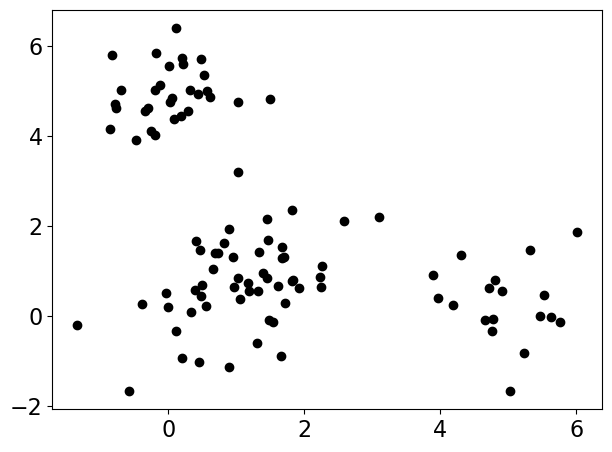

In [15]:
plt.figure()
d = np.vstack(data)
plt.plot(d[:,0], d[:,1],'ko')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

In [16]:
import plotly.graph_objs as go
import numpy as np

# Assuming 'data' is already defined
d = np.vstack(data)

# Create a scatter plot
scatter = go.Scatter(x=d[:, 0], y=d[:, 1], mode='markers', marker=dict(color='black'))

# Set the layout with font size
layout = go.Layout(font=dict(size=16))

# Create the Figure with the scatter plot and layout
fig = go.Figure(data=[scatter], layout=layout)

# Show the figure
fig.show()

In [35]:
# experiment with np.random.choice
init_weights = [1/4., 1/2., 1/4.]
k = np.random.choice(len(weights), 1, p=weights)
k

array([1])

In [36]:
print("data", np.array(data))

data [[ 3.18453675e-01  5.03182099e+00]
 [ 1.45029339e+00  2.15717573e+00]
 [ 1.02645431e+00  4.76042375e+00]
 [ 5.23493625e+00 -8.11388508e-01]
 [ 4.65710743e+00 -8.53235111e-02]
 [ 4.37465532e-01  4.93778385e+00]
 [-1.27563734e-01  5.14296293e+00]
 [ 4.18200738e+00  2.48192467e-01]
 [ 1.65646672e+00 -8.79913691e-01]
 [-6.95080064e-01  5.03848976e+00]
 [ 6.01348014e+00  1.87722666e+00]
 [ 2.00992080e-01 -9.32132035e-01]
 [-3.82682220e-01  2.63653736e-01]
 [ 5.03394554e+00 -1.66740986e+00]
 [ 1.53889119e+00 -1.27317151e-01]
 [ 8.14486167e-01  1.63543709e+00]
 [ 1.72192430e+00  2.84607146e-01]
 [ 4.90757786e+00  5.67160884e-01]
 [ 6.05120657e-01  4.87555125e+00]
 [ 1.30867865e+00 -5.87110447e-01]
 [ 1.95706545e-01  5.73836612e+00]
 [ 3.97078181e+00  3.93282343e-01]
 [ 4.71907770e-01  1.47637309e+00]
 [ 1.32157017e+00  5.64863684e-01]
 [ 3.89988459e+00  9.24332035e-01]
 [ 1.12054884e-01  6.40720120e+00]
 [ 4.07173152e-01  1.67134485e+00]
 [ 5.62315318e-01  5.01349864e+00]
 [ 1.82113515e+

In [60]:
np.random.seed(4)

# Initialization of parameters
chosen = np.random.choice(len(data), 3, replace=False)
initial_means = [data[x] for x in chosen]
initial_covs = [np.cov(data, rowvar=0)] * 3
initial_weights = [1/3.] * 3



## Plot initial covariancees and Mean

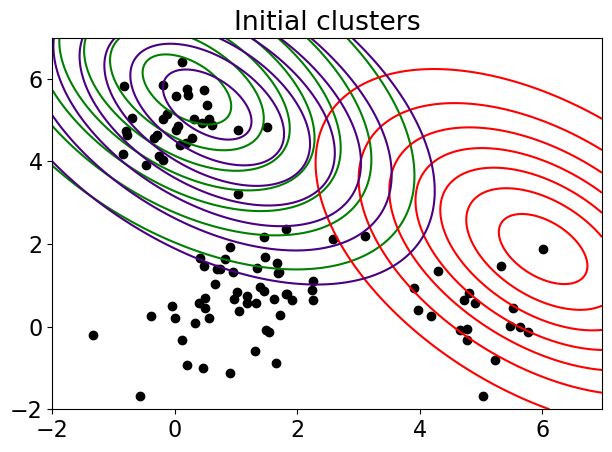

In [61]:
import matplotlib.mlab as mlab
from scipy.stats import multivariate_normal
def plot_contours(data, means, covs, title):
    plt.figure()
    plt.plot([x[0] for x in data], [y[1] for y in data],'ko') # data

    delta = 0.025
    k = len(means)
    x = np.arange(-2.0, 7.0, delta)
    y = np.arange(-2.0, 7.0, delta)
    X, Y = np.meshgrid(x, y)
    col = ['green', 'red', 'indigo']
    for i in range(k):
        mean = means[i]
        cov = covs[i]
        sigmax = np.sqrt(cov[0][0])
        sigmay = np.sqrt(cov[1][1])
        sigmaxy = cov[0][1]/(sigmax*sigmay)
        rv = multivariate_normal(mean, cov)

        # Evaluate the PDF on a grid of points
        Z = rv.pdf(np.dstack((X, Y)))
#         Z = mlab.bivariate_normal(X, Y, sigmax, sigmay, mean[0], mean[1], sigmaxy)
        plt.contour(X, Y, Z, colors = col[i])
        plt.title(title)
    plt.rcParams.update({'font.size':16})
    plt.tight_layout()
    
plot_contours(data, initial_means, initial_covs, 'Initial clusters')

## run EM, find out final clusters and Mean

In [62]:
# Run EM 
results = EM(data, initial_means, initial_covs, initial_weights)

Iteration 0
Iteration 5
Iteration 10
Iteration 15
Iteration 20
Iteration 22


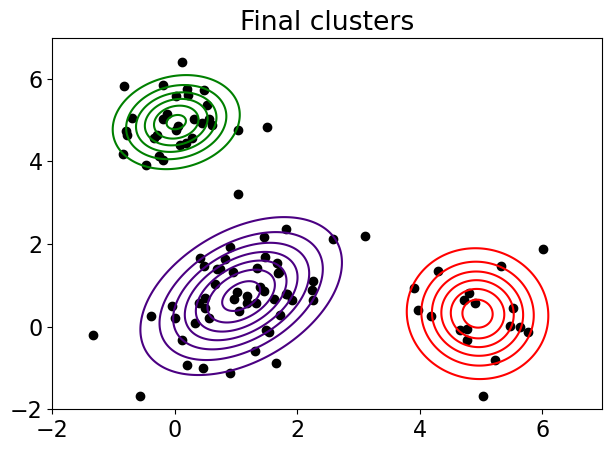

In [63]:

plot_contours(data, results['means'], results['covs'], 'Final clusters')

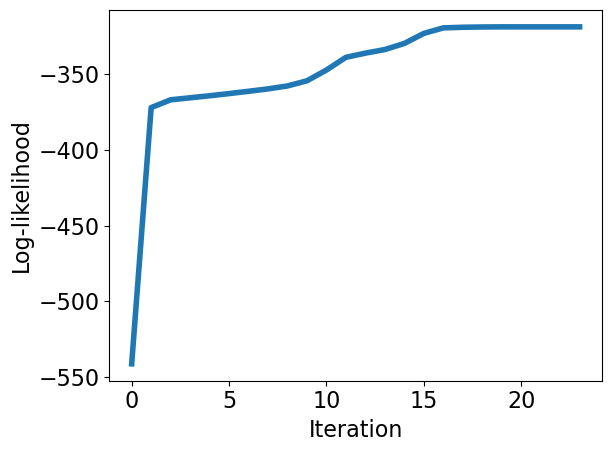

In [64]:

loglikelihoods = results['loglik']
plt.plot(range(len(loglikelihoods)), loglikelihoods, linewidth=4)
plt.xlabel('Iteration')
plt.ylabel('Log-likelihood')
plt.rcParams.update({'font.size':16})
plt.tight_layout()